Tutorial Article:

https://towardsdatascience.com/building-a-graph-based-grocery-recommender-in-dash-on-aws-3d96d262e365

word2vec documentation: https://radimrehurek.com/gensim/models/word2vec.html

https://github.com/NeilSinclair/GroceryNetwork/blob/master/Basket%20Network%20Analysis-DeepWalk.ipynb

https://towardsdatascience.com/deepwalk-its-behavior-and-how-to-implement-it-b5aac0290a15

https://github.com/AntonsRuberts/graph_ml/blob/main/Facebook%20-%20DeepWalk%20and%20Node2Vec.ipynb

https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial

https://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W467ScBjM2x

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## Make sure to create a new folder and change to your own directory
%cd /content/drive/Shareddrives/'DATA 245 Team 6'/Datasets/
%ls


/content/drive/Shareddrives/DATA 245 Team 6/Datasets
 amazon_products.pickle  'Dataset Links.gdoc'   rapidsai-csp-utils/  'review vector db'/
 dataset_for_modeling/    Movie_TV/            'raw files'/           word2vec/


In [3]:
import pandas as pd
import numpy as np

import random

import plotly.offline as py
import plotly.graph_objects as go

import networkx as nx
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

from tqdm.notebook import tqdm



import pickle
import json

from gensim.models import Word2Vec

import string



In [4]:
books_meta = pd.read_csv("dataset_for_modeling/books_amzn_meta.csv").rename(columns={'Unnamed: 0':"asin"})

In [5]:
train = books_meta.dropna()

In [6]:
train

,asin,Id,title,group,categories,connections,salesrank,tot_reviews,avg_rating,degree_centrality,clustering_coeff
0,0827229534,1,Patterns of Preaching: A Sermon Sampler,Book,subject religion sermon preach christian book ...,0804215715 156101074X 0687023955 0687074231 08...,396585,2,5.0,0,0.0
1,0738700797,2,Candlemas: Feast of Flames,Book,spiritu subject religion witchcraft wicca book...,0738700827 1567184960 1567182836 0738700525 07...,168596,12,4.5,0,0.0
3,0842328327,4,Life Application Bible Commentary: 1 and 2 Tim...,Book,sacr applic general histori religion studi sub...,0842328130 0842330313 0842328610 0842328572,631289,1,4.0,0,0.0
4,1577943082,5,Prayers That Avail Much for Business: Executive,Book,subject religion busi devot prayerbook worship...,157794349X 0892749504 1577941829 0892749563,455160,0,0.0,0,0.0
5,0486220125,6,How the Other Half Lives: Studies Among the Te...,Book,art scienc general histori subject social jewi...,0486401960 0452283612 0486229076 0714840343,188784,17,4.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
393550,0838409342,548534,Abriendo Paso Lectura,Book,subject refer book general,0838426069 080131531X 0805366245,0,2,4.5,0,0.0
393552,B00006RGI2,548537,Anyway: The Paradoxical Commandments: Finding ...,Book,religion store categori amazon specialti com b...,0517163101 1930722052 0887306314 0385468059,0,17,4.5,0,0.0
393554,B00008MNUJ,548539,A Matter of Degrees: What Temperature Reveals ...,Book,store subject categori amazon scienc specialti...,0822959046 0195093852 0618118128,0,6,5.0,0,0.0
393555,0060537612,548540,If You Take a Mouse Five-Book Set (If You Take...,Book,fiction subject book humor anim general litera...,0689808747 0689820305 0859531821 0060266864 09...,0,4,5.0,0,0.0


In [7]:
title_conn = train[['asin','title','categories','connections']].copy()
title_conn['title'] = title_conn['title'].apply(lambda x: x.replace(" ","_").replace('"', ''))
title_conn['categories_split'] = title_conn['categories'].apply(lambda x:x.split())

In [ ]:
asin_title = dict(zip(title_conn.asin, title_conn.title))
asin_title

In [15]:
title_cat = dict(zip(title_conn.title, title_conn.categories_split))

In [ ]:
co_purchase_pairs = {}

for i,row in tqdm(title_conn.iterrows()):
  conns = row['connections'].split(' ')
  pair = [(row['title'],asin_title.get(i)) for i in conns if asin_title.get(i)is not None ]
  for p in pair:
    if p[0] != p[1]:
      if p in co_purchase_pairs.keys():
        co_purchase_pairs[p] +=1
      else:
        co_purchase_pairs[p] = 1

0it [00:00, ?it/s]

In [ ]:
with open('word2vec/co_purchase_pairs.pkl', 'wb') as f:
  pickle.dump(co_purchase_pairs, f)

In [ ]:
len(co_purchase_pairs)

834466

In [ ]:
from math import log, e

def entropy(labels, base=None):
  """ Computes entropy of label distribution. """

  n_labels = len(labels)

  if n_labels <= 1:
    return 0

  value,counts = np.unique(labels, return_counts=True)
  probs = counts / n_labels
  n_classes = np.count_nonzero(probs)

  if n_classes <= 1:
    return 0

  ent = 0.

  # Compute entropy
  base = e if base is None else base
  for i in probs:
    ent -= i * log(i, base)

  return ent

# cat1 = train.query("asin == '0827229534'").categories.values[0].split()
# cat2 = train.query("asin == '0738700797'").categories.values[0].split()
# print(cat1 + cat2)
# entropy(cat1 + cat2)

['subject', 'religion', 'sermon', 'preach', 'christian', 'book', 'spiritu', 'clergi', 'spiritu', 'subject', 'religion', 'witchcraft', 'wicca', 'book', 'base', 'earth']


2.4260151319598084

In [ ]:
weighted_co_purchase_pairs =  {}

for i,row in tqdm(title_conn.iterrows()):
  conns = row['connections'].split(' ')
  pair = [(row['title'],asin_title.get(i)) for i in conns if asin_title.get(i)is not None ]
  for p in pair:
    if p[0] != p[1]:
      if p in weighted_co_purchase_pairs.keys():
        weighted_co_purchase_pairs[p] += (1 * entropy(title_cat.get(p[0]) + title_cat.get(p[1])))
      else:
        weighted_co_purchase_pairs[p] = (1 * entropy(title_cat.get(p[0]) + title_cat.get(p[1])))

0it [00:00, ?it/s]

In [ ]:
with open('word2vec/weighted_co_purchase_pairs.pkl', 'wb') as f:
  pickle.dump(weighted_co_purchase_pairs, f)

In [ ]:
d = [dict(sorted(co_purchase_pairs.items(), key=lambda x:x[1], reverse=True))]
d_weighted = [dict(sorted(weighted_co_purchase_pairs.items(), key=lambda x:x[1], reverse=True))]

In [ ]:
# Create and populate the graph object
G = nx.Graph()

for key, val in d[0].items():
    G.add_edge(key[0], key[1], weight = val)

# Take a look at how many nodes there are in the graph; too many and it's uncomfortable to visualise
nodes = list(G.nodes)
len(nodes)

245242

In [ ]:
# Prune the plot so we only have items that are matched with at least two others
for node in nodes:
    try:
        if G.degree[node] <= 1:
            G.remove_node(node)
    except:
        print(f'error with node {node}')

nodes = list(G.nodes)
len(nodes)

224597

In [ ]:
# Create and populate the graph object
G_weighted = nx.Graph()

for key, val in d_weighted[0].items():
    G_weighted.add_edge(key[0], key[1], weight = val)

# Take a look at how many nodes there are in the graph; too many and it's uncomfortable to visualise
nodes_weighted = list(G_weighted.nodes)
print(len(nodes_weighted))

# Prune the plot so we only have items that are matched with at least two others
for node in nodes_weighted:
    try:
        if G_weighted.degree[node] <= 1:
            G_weighted.remove_node(node)
    except:
        print(f'error with node {node}')

nodes = list(G_weighted.nodes)
print(len(nodes_weighted))

245242
245242


In [ ]:

# Cycle through all of the nodes and build a dictionary that contains the edge weights. It was necessary to
# do this upfront to speed up processing in the next step

weights = {}
for node in tqdm(G.nodes()):
    w_ = []
    for nodes in list(G.edges(str(node))):
        w_.append(G.get_edge_data(nodes[0], nodes[1])['weight'])
    weights[node]=w_

  0%|          | 0/224597 [00:00<?, ?it/s]

In [ ]:
def random_walk(graph, node, weighted=False, n_steps = 5):
    ''' Function that takes a random walk along a graph
    Most code borrowed from: https://towardsdatascience.com/deepwalk-its-behavior-and-how-to-implement-it-b5aac0290a15
    params: graph - the networkx graph object
            node - the node to start on
            weighted - whether the probability of moving to a new node is determined by the edge weight
            n_steps - the number of steps to take
    Returns a "string" of the nodes visited
    '''
    local_path = [str(node),]
    target_node = node
      # Take n_steps random walk away from the node (can return to the node)
    for _ in range(n_steps):
        #print(list(nx.all_neighbors(graph, target_node)))
        neighbours = list(nx.all_neighbors(graph, target_node))
        if weighted:
            # sample in a weighted manner
            target_node = random.choices(neighbours,weights[target_node])[0]
        else:
            target_node = random.choice(neighbours)
        local_path.append(str(target_node))

    return local_path

In [ ]:

##  Take a weighted walk  ##
walk_paths_weighted = []

i = 0
for node in tqdm(G.nodes()):
    # We take 10 random walk from each node
    try:
      for _ in range(10):
          walk_paths_weighted.append(random_walk(G, node, weighted=True))
    except:
      pass

<ipython-input-202-353a26c0315e>:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/224609 [00:00<?, ?it/s]

In [ ]:
# with open('walk_paths_weighted.pkl', 'wb') as f:
#   pickle.dump(walk_paths_weighted, f)

In [ ]:
with open("word2vec/walk_paths_weighted.pkl", "rb") as input_file:
  walk_paths_weighted = pickle.load(input_file)

In [ ]:
## Create your node embeddings ##
# Instantiate the embedder
embedder = Word2Vec(window = 4, sg=1, negative=10, alpha=0.03, min_alpha=0.0001, seed=42)
# Build the vocab
embedder.build_vocab(walk_paths_weighted, progress_per=2)
# Train the embedder to build the word embeddings
embedder.train(walk_paths_weighted, total_examples=embedder.corpus_count, epochs=20, report_delay=1)

(269400000, 269400000)

In [8]:
#embedder.save("books_word2vec.model")
embedder = Word2Vec.load("word2vec/books_word2vec.model")

In [9]:
with open('dataset_for_modeling/books_dict.json', 'r') as openfile:
    books_dict = json.load(openfile)

In [22]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=arrays.shape[0]).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(10)


    # plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    # plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)

    plt.title('t-SNE visualization for {}'.format(word.title()))


In [18]:
query = "Patterns of Preaching: A Sermon Sampler"

In [12]:
title_conn

,asin,title,categories,connections,categories_split
0,0827229534,Patterns_of_Preaching:_A_Sermon_Sampler,subject religion sermon preach christian book ...,0804215715 156101074X 0687023955 0687074231 08...,"[subject, religion, sermon, preach, christian,..."
1,0738700797,Candlemas:_Feast_of_Flames,spiritu subject religion witchcraft wicca book...,0738700827 1567184960 1567182836 0738700525 07...,"[spiritu, subject, religion, witchcraft, wicca..."
3,0842328327,Life_Application_Bible_Commentary:_1_and_2_Tim...,sacr applic general histori religion studi sub...,0842328130 0842330313 0842328610 0842328572,"[sacr, applic, general, histori, religion, stu..."
4,1577943082,Prayers_That_Avail_Much_for_Business:_Executive,subject religion busi devot prayerbook worship...,157794349X 0892749504 1577941829 0892749563,"[subject, religion, busi, devot, prayerbook, w..."
5,0486220125,How_the_Other_Half_Lives:_Studies_Among_the_Te...,art scienc general histori subject social jewi...,0486401960 0452283612 0486229076 0714840343,"[art, scienc, general, histori, subject, socia..."
...,...,...,...,...,...
393550,0838409342,Abriendo_Paso_Lectura,subject refer book general,0838426069 080131531X 0805366245,"[subject, refer, book, general]"
393552,B00006RGI2,Anyway:_The_Paradoxical_Commandments:_Finding_...,religion store categori amazon specialti com b...,0517163101 1930722052 0887306314 0385468059,"[religion, store, categori, amazon, specialti,..."
393554,B00008MNUJ,A_Matter_of_Degrees:_What_Temperature_Reveals_...,store subject categori amazon scienc specialti...,0822959046 0195093852 0618118128,"[store, subject, categori, amazon, scienc, spe..."
393555,0060537612,If_You_Take_a_Mouse_Five-Book_Set_(If_You_Take...,fiction subject book humor anim general litera...,0689808747 0689820305 0859531821 0060266864 09...,"[fiction, subject, book, humor, anim, general,..."


In [16]:
# show original copurchased items
query_conns = title_conn.query(f'title == "{query}"')['connections'].values[0].split()
[asin_title.get(i) for i in query_conns]

['Witness_of_Preaching',
 'The_Preaching_Life',
 'The_Four_Pages_of_the_Sermon:_A_Guide_to_Biblical_Preaching',
 'Performing_the_Word:_Preaching_As_Theatre',
 'Interpreting_the_Gospel:_An_Introduction_to_Preaching']

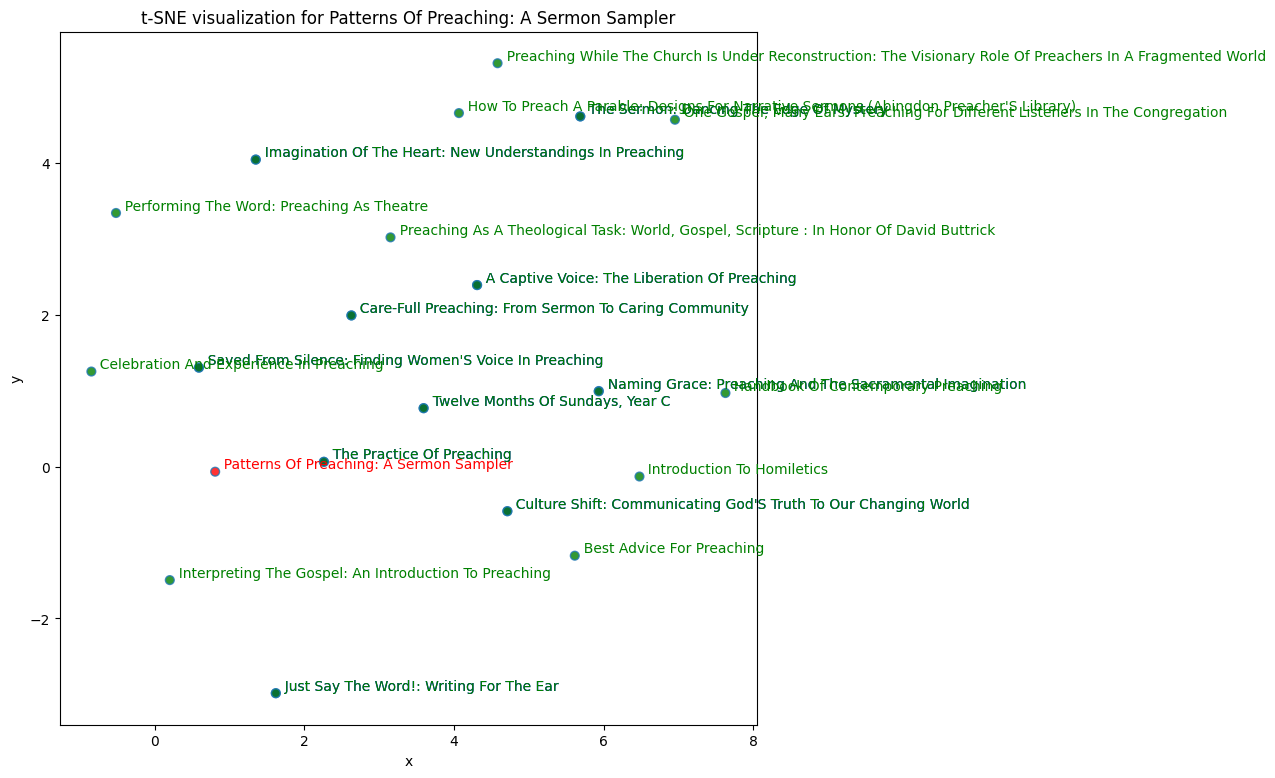

In [23]:
x_ = embedder.wv.most_similar(query, topn=20)

#return similar titles from random walk
tsnescatterplot(embedder, query, [i[0] for i in x_])


In [25]:
pd.DataFrame(x_,columns=['title','similarity_score'])

,title,similarity_score
0,Saved from Silence: Finding Women's Voice in P...,0.963462
1,The Practice of Preaching,0.962883
2,Care-Full Preaching: From Sermon to Caring Com...,0.960592
3,"Twelve Months of Sundays, Year C",0.960347
4,Culture Shift: Communicating God's Truth to Ou...,0.955734
5,A Captive Voice: The Liberation of Preaching,0.955004
6,Imagination of the Heart: New Understandings i...,0.950684
7,Just Say the Word!: Writing for the Ear,0.945026
8,The Sermon: Dancing the Edge of Mystery,0.944450
9,Naming Grace: Preaching and the Sacramental Im...,0.943668


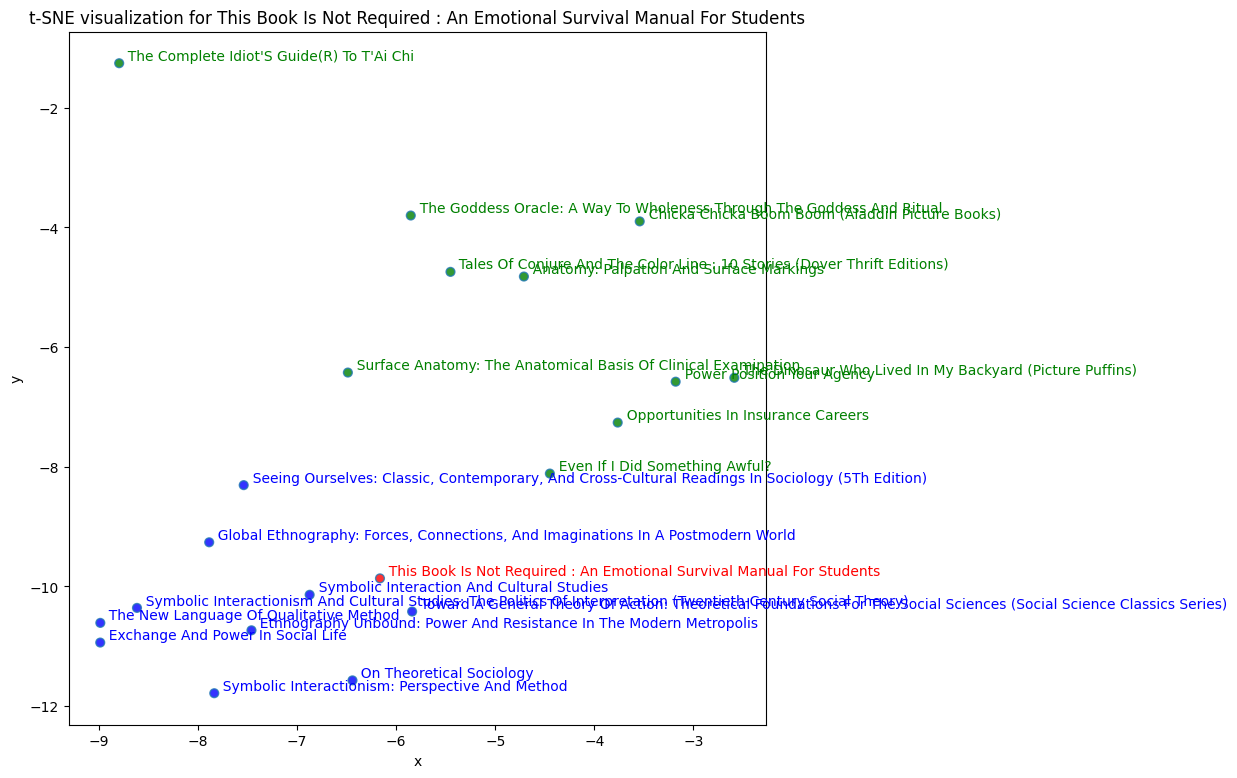

In [ ]:
bq = title_conn['title'].sample(1).values[0]
try:
  tsnescatterplot(embedder, bq, [i[0] for i in embedder.wv.most_similar(negative=[bq])])
except Exception as e:
    print(repr(e))

the vector representation of query and 10 most similar books from the model lies compare to the vector representation of the 10 most dissimilar words to query

## Evaluate

### calculate similarity
`w2v_model.wv.similarity('maggie', 'baby')`
- returns 0.68336403


### odd-one-out:

`w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])`
-  returns 'milhouse'




In [ ]:
title_conn['title'].sample(5).values

array(['Saving Private Ryan',
       'Everyday Fashions of the Sixties as Pictured in Sears Catalogs (Sears Catalogs)',
       'Neuroscience for the Mental Health Clinician',
       "The Only Ekg Book You'll Ever Need", 'The Sociology of Religion'],
      dtype=object)

In [ ]:
random_n = title_conn['title'].sample(5).values
print(random_n)
print()
embedder.wv.doesnt_match(random_n)

['The Day After Roswell'
 'Pumping Insulin: Everything You Need for Success With an Insulin Pump'
 'Alcoholism, Narcissism, and Psychopathology (Master Work Series)'
 'Choral Conducting Symposium, Second Edition' 'The Real Thing']



'Pumping Insulin: Everything You Need for Success With an Insulin Pump'

In [ ]:
bq = title_conn['title'].sample(1).values[0]
print(bq,'\n')
try:
  res = embedder.wv.most_similar(negative=[bq], topn=20)

  for r in res:
    print('\t - ',r[0],': ',embedder.wv.similarity(bq, r[0]))
    print()
except Exception as e:
    print(repr(e))

The Boa Constrictor Manual (The Herpetocultural Library) 

	 -  Boundaries of the Soul :  0.07852547

	 -  Aging Without Growing Old :  0.08084374

	 -  At Home with Art : How Art Lovers Live with and Care for Their Treasures :  0.08760535

	 -  In Short: A Collection of Brief Creative Nonfiction :  0.097634576

	 -  The Necessary Shakespeare :  0.09963299

	 -  Modern Woman in Search of Soul: A Jungian Guide to the Visible and Invisible Worlds (Jung on the Hudson Books) :  0.10050715

	 -  A Book of Angels :  0.10127298

	 -  The Visual Display of Quantitative Information :  0.102898404

	 -  Intentional Interviewing and Counseling (with InfoTrac and CD-ROM) : Facilitating Client Development in a Multicultural Society :  0.10351004

	 -  Androgyny: The Opposites Within (Jung on the Hudson Book Series) :  0.10492353

	 -  The Heart of Psychotherapy : The Most Honest, Revealing, Fascinating Account of What Goes On In Therapy :  0.10526145

	 -  Where Angels Walk :  0.10529307

	 -  Prec

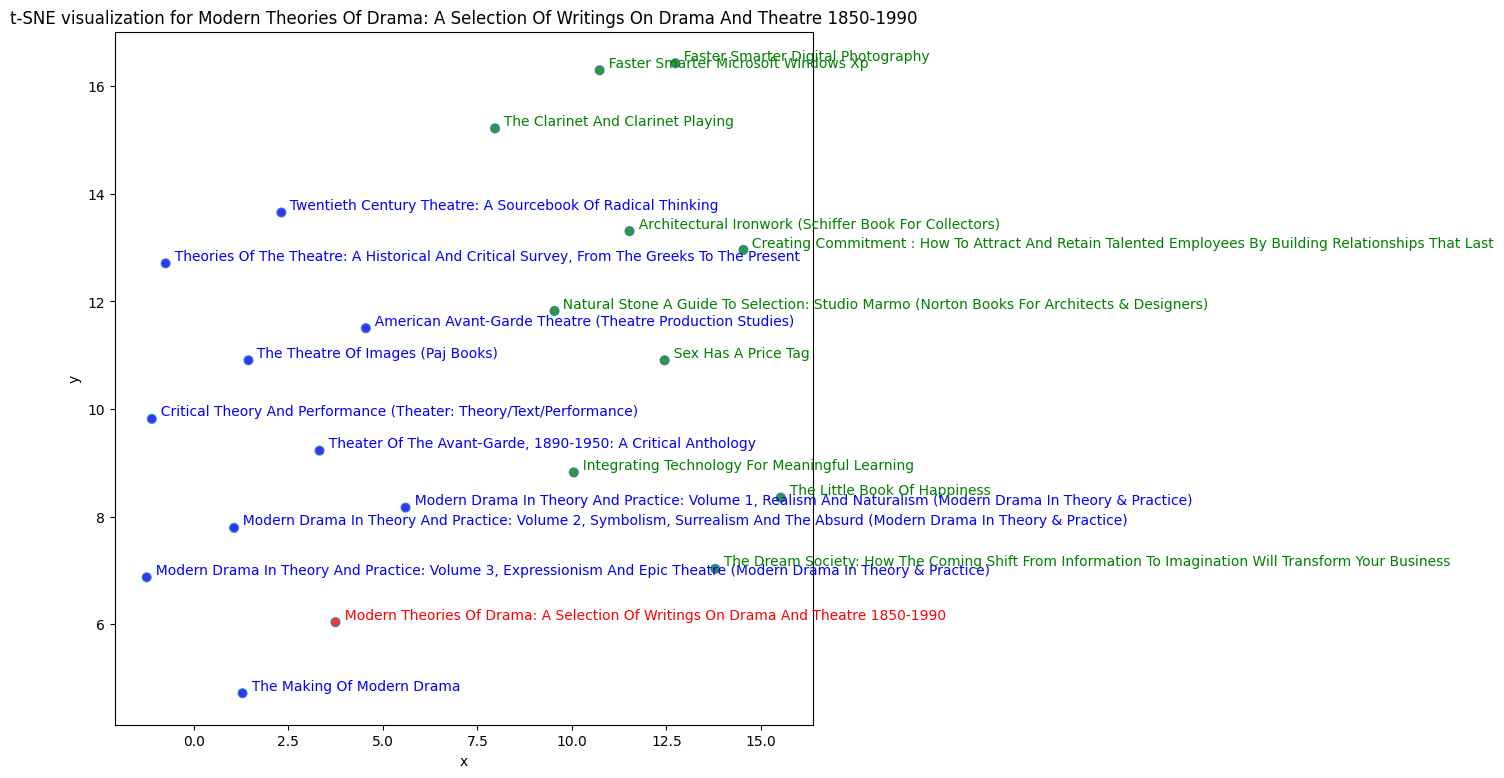

In [ ]:
bq = title_conn['title'].sample(1).values[0]
try:
  tsnescatterplot(embedder, bq, [i[0] for i in embedder.wv.most_similar(negative=[bq], topn=20)][10:])
except Exception as e:
    print(repr(e))